In [ ]:
!pip install Pillow==9.0.0

In [ ]:
!pip install fashion-clip transformers torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.9 MB/s eta 0:00:00


In [ ]:
from PIL import Image, ImageOps, ImageDraw
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


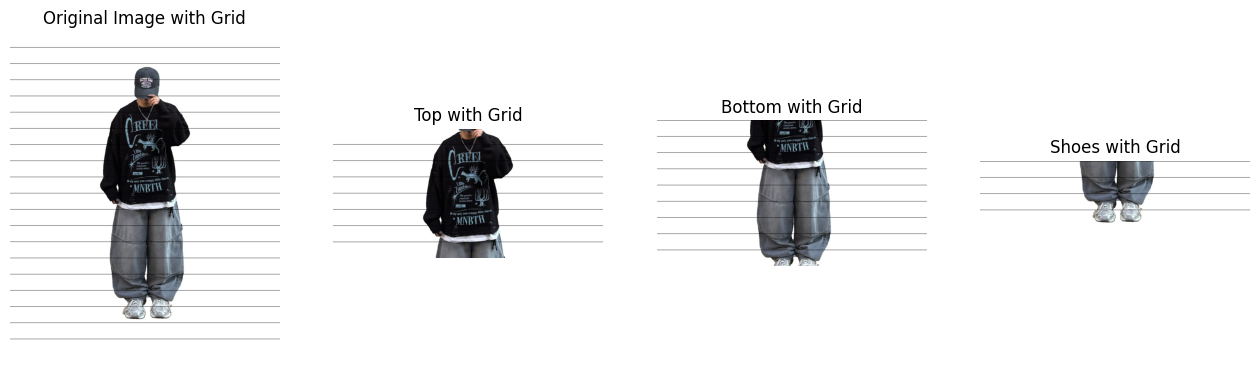

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load the image
img = Image.open("/content/drive/MyDrive/오뭐입/algorithm/segmented_143.jpg")

# Create a copy of the image to add the grid
grid_img = img.copy()
draw = ImageDraw.Draw(grid_img)

# Calculate height for each segment (20 segments)
segment_height = grid_img.height // 20

# Draw horizontal lines for each segment (20 segments)
for i in range(1, 20):  # We need 19 lines to divide into 20 parts
    y = i * segment_height
    draw.line([(0, y), (grid_img.width, y)], fill="black", width=2)  # Adjust color and width if needed

# Crop areas with the grid included
top_crop1 = 4 * segment_height
bottom_crop1 = 12 * segment_height
top_image = grid_img.crop((0, top_crop1, grid_img.width, bottom_crop1))

top_crop2 = 8 * segment_height
bottom_crop2 = 17 * segment_height
pants_image = grid_img.crop((0, top_crop2, grid_img.width, bottom_crop2))

top_crop3 = 14 * segment_height
bottom_crop3 = 18 * segment_height
shoes_image = grid_img.crop((0, top_crop3, grid_img.width, bottom_crop3))

# Display the original image with grid and cropped images with grid in a single row
plt.figure(figsize=(16, 8))

# Display original image with grid
plt.subplot(1, 4, 1)  # (1 row, 4 columns, position 1)
plt.imshow(grid_img)
plt.title("Original Image with Grid")
plt.axis("off")  # Hide axes

# Display top_image with grid
plt.subplot(1, 4, 2)  # (1 row, 4 columns, position 2)
plt.imshow(top_image)
plt.title("Top with Grid")
plt.axis("off")  # Hide axes

# Display pants_image with grid
plt.subplot(1, 4, 3)  # (1 row, 4 columns, position 3)
plt.imshow(pants_image)
plt.title("Bottom with Grid")
plt.axis("off")  # Hide axes

# Display shoes_image with grid
plt.subplot(1, 4, 4)  # (1 row, 4 columns, position 4)
plt.imshow(shoes_image)
plt.title("Shoes with Grid")
plt.axis("off")  # Hide axes

# Show all images
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from fashion_clip import attention_map
from tqdm.notebook import tqdm

class What2Wear:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.categories = ["Top", "Bottom", "Shoes"]
        self.input_dim = 512
        self.output_dim = 128

    def add_equal_white_padding(image, threshold=300):
        # Convert the image to grayscale for border detection
        gray_img = image.convert("L")
        np_img = np.array(gray_img)

        # Detect non-white areas (using a slightly relaxed threshold)
        non_white = np.where(np_img < threshold)

        # Ensure there are non-white areas detected to avoid errors
        if non_white[0].size == 0 or non_white[1].size == 0:
            return image  # If no non-white pixels, return the original image

        # Find top, bottom (y-coordinates), left, and right (x-coordinates) bounds of non-white regions
        top, bottom = non_white[0][0], non_white[0][-1]
        left, right = non_white[1][0], non_white[1][-1]

        # Crop white borders
        cropped_img = image.crop((left, top, right, bottom))

        # Calculate padding sizes for square dimensions
        padding_vertical = max(0, (image.height - (bottom - top)) // 2)
        padding_horizontal = max(0, (image.width - (right - left)) // 2)

        # Add equal padding on all sides
        final_img = ImageOps.expand(
            cropped_img,
            border=(padding_horizontal, padding_vertical),
            fill="white"
        )

        return final_img

    def crop_and_embed_image(self, top_height, bottom_height, image):
        segment_height = image.height // 20

        top_crop = top_height * segment_height
        bottom_crop = bottom_height * segment_height
        cropped_img = image.crop((0, top_crop, image.width, bottom_crop))

        with torch.no_grad():
            inputs = self.processor(images=cropped_img, return_tensors="pt", padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            embedding = self.model.get_image_features(**inputs)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)

        return cropped_img, embedding

    def process_image(self, image_path):
        results = {}
        original_image = Image.open(image_path)

        for category in self.categories:
          if category == "Top":
            top_height = 4
            bottom_height = 12
          elif category == "Bottom":
            top_height = 8
            bottom_height = 17
          elif category == "Shoes":
            top_height = 14
            bottom_height = 18
          cropped_image, embedding = self.crop_and_embed_image(top_height, bottom_height, original_image)
          results[category] = {
              'cropped_image': cropped_image,
              'embedding': embedding
          }

        return results

    def generate_outfit_vector(self, results):
        # "outer"와 "top" 중 더 큰 범위의 박스를 선택
        top_result = results.get("Top")
        bottom_result = results.get("Bottom")
        shoes_result = results.get("Shoes")

        # 카테고리 임베딩 추가
        top_embedding = top_result["embedding"].squeeze() if top_result and "embedding" in top_result else torch.zeros(self.input_dim, device=self.device )
        bottom_embedding = bottom_result["embedding"].squeeze() if bottom_result and "embedding" in bottom_result else torch.zeros(self.input_dim, device=self.device)
        shoes_embedding = shoes_result["embedding"].squeeze() if shoes_result and "embedding" in shoes_result else torch.zeros(self.input_dim, device=self.device)

        # 최종 코디 벡터를 (3, 512) 차원으로 생성
        outfit_vector = torch.stack([top_embedding, bottom_embedding, shoes_embedding])

        return outfit_vector



    def visualize_results(self, image_path, results, outfit_vector):
        # 원본 이미지 로드
        original_image = Image.open(image_path)

        # 플롯 설정 (각 카테고리에 대해 하나의 열만 사용)
        fig, axs = plt.subplots(len(self.categories) + 1, 1, figsize=(6, 5 * (len(self.categories) + 1)))
        fig.tight_layout(pad=3.0)

        # 첫 번째 플롯에 원본 이미지 표시
        axs[0].imshow(original_image)
        axs[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axs[0].axis('off')  # 축 제거

        # 색상 지정
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.categories)))

        # 카테고리별 크롭된 이미지 및 임베딩 정보 표시
        for idx, category in enumerate(self.categories, start=1):
            result = results.get(category, None)

            if result:
                cropped_image = result['cropped_image']

                # 크롭된 이미지 표시
                axs[idx].imshow(cropped_image)
                axs[idx].set_title(f"Cropped - {category}", fontsize=12, color=colors[idx-1])
                axs[idx].axis('off')  # 축 제거

                # 임베딩 정보 표시
                if 'embedding' in result:
                    embedding_shape_text = f"Embedding Shape: {result['embedding'].shape}"
                    axs[idx].text(0.5, -0.1, embedding_shape_text,
                                  ha='center', va='top', transform=axs[idx].transAxes, fontsize=10, color="gray")
            else:
                # 결과가 없는 경우 메시지 표시
                axs[idx].axis('off')
                axs[idx].text(0.5, 0.5, f"No result for {category}",
                              ha='center', va='center', transform=axs[idx].transAxes, fontsize=12, color="red", fontweight='bold')

        # 전체 레이아웃 조정
        plt.subplots_adjust(top=0.95)
        plt.suptitle("Outfit Visualization", fontsize=16, fontweight='bold')
        plt.show()

        # 아웃핏 벡터 출력
        print("Outfit Vector Shape:", outfit_vector.shape)
        print("Outfit Vector:", outfit_vector)


# Usage example:
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# what2wear = What2Wear(model, processor)
#
# pixel_sizes = {cat: 10 for cat in what2wear.categories}
# iterations = {cat: 5 for cat in what2wear.categories}
# heat_thresholds = {cat: 0.5 for cat in what2wear.categories}
#
# image_path = "path/to/your/outfit_image.jpg"
# results = what2wear.process_image(image_path, pixel_sizes, iterations, heat_thresholds)
# outfit_vector = what2wear.generate_outfit_vector(results)
# what2wear.visualize_results(image_path, results, outfit_vector)

In [ ]:
model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")
what2wear = What2Wear(model, processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
image_path = "/content/drive/MyDrive/오뭐입/data/dataset/outfit_SAM/segmented_10784.jpg"
results = what2wear.process_image(image_path)

In [ ]:
outfit_vector = what2wear.generate_outfit_vector(results)

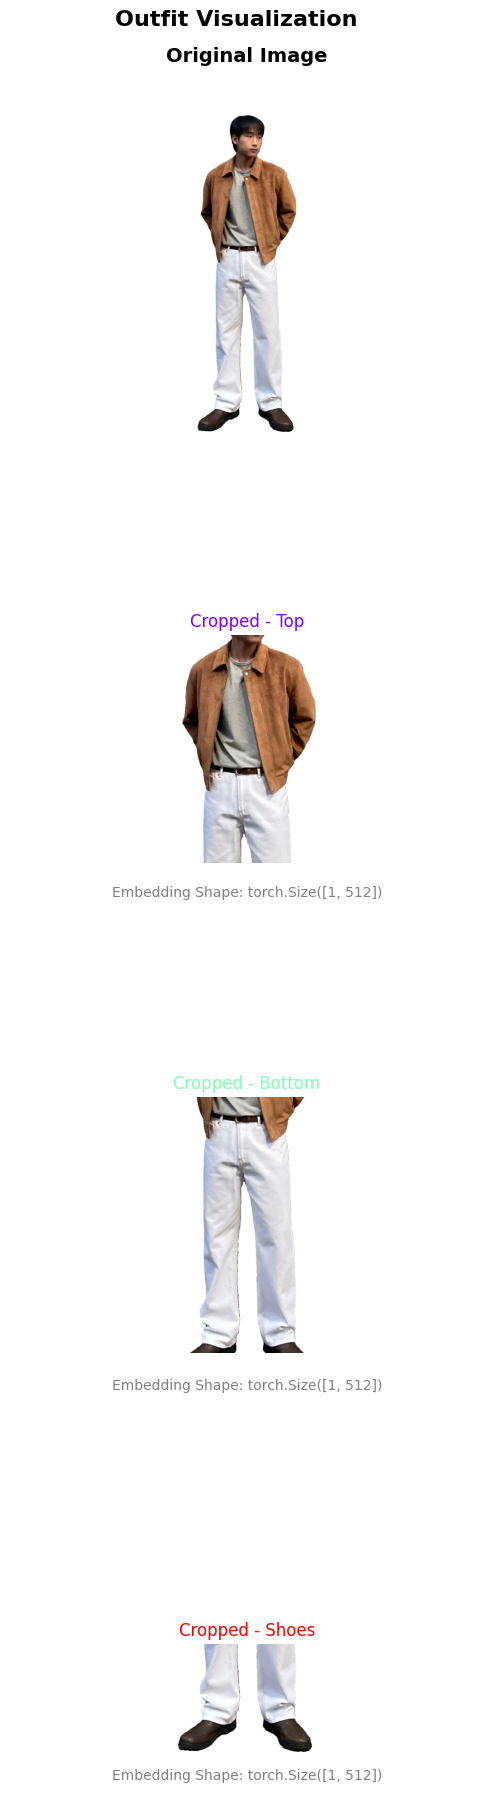

Outfit Vector Shape: torch.Size([3, 512])
Outfit Vector: tensor([[-0.0459, -0.0420, -0.0612,  ...,  0.0012, -0.0250, -0.0191],
        [-0.0209, -0.0857, -0.1569,  ...,  0.0072, -0.0179, -0.0018],
        [-0.0385, -0.1070, -0.1140,  ..., -0.0075,  0.0131, -0.0613]])


In [ ]:
what2wear.visualize_results(image_path, results, outfit_vector)

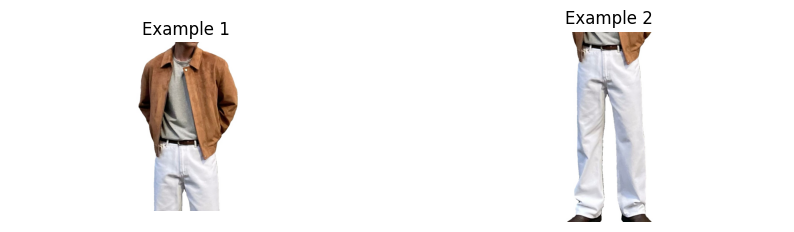

Example 1 key : blue short sleeve check shirts with western style line at chest
tensor([[1.7732e-04, 4.7472e-04, 3.7191e-08, 2.0069e-09, 1.3671e-09, 6.9038e-09,
         2.6873e-10, 3.0095e-11, 9.9935e-01]], grad_fn=<SoftmaxBackward0>)
Max Similarity Text: Outer trucker jacket, brown color, standard fit, botton on top
Probability: 0.999347984790802


Example 2 key : gray wide pants with green nylon detail
tensor([[1.3935e-04, 5.4073e-04, 2.5170e-06, 1.5749e-04, 3.1850e-07, 5.4047e-04,
         1.6544e-05, 9.9994e-06, 2.0437e-07, 9.9859e-01]],
       grad_fn=<SoftmaxBackward0>)
Max SimilartiyText: blue denim pantsDenim Pants with white color standar fit
Probability: 0.9985924363136292

Example 3 key : blue short sleeve check shirts with western style line at chest
tensor([[2.8490e-06, 1.1633e-01, 3.3872e-07, 9.9378e-09, 3.6525e-09, 2.0889e-08,
         7.2668e-11, 6.3971e-11, 8.8367e-01]], grad_fn=<SoftmaxBackward0>)
Max Similarity Text: Outer trucker jacket, brown color, standard fit, 

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# 모델 정의
model1 = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor1 = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")

model2 = CLIPModel.from_pretrained("/content/drive/MyDrive/오뭐입/finetuning/fine_tuned_model3")
processor2 = CLIPProcessor.from_pretrained("/content/drive/MyDrive/오뭐입/finetuning/fine_tuned_model3")

# 이미지 로드
image1 = Image.open("/content/drive/MyDrive/오뭐입/sample/3976540_17121922695848_big.jpg")
image2 = Image.open("/content/drive/MyDrive/오뭐입/sample/3428758_16903564736541_big.jpg.webp")

image1 = what2wear.process_image(image_path).get("Top",{}).get("cropped_image")
image2 = what2wear.process_image(image_path).get("Bottom",{}).get("cropped_image")

# 텍스트 리스트
texts1 = ["shirts",
         "brown check shirts",
         "blue check shirts",
         "blue short sleeve check shirts",
         "blue short sleeve check shirts with line detail on the chest",
         "blue short sleeve check shirts with western style line on chest",
          "hoodie with perscene logo black color",
          "Tshirt with white lettering logo, black color",
          "Outer trucker jacket, brown color, standard fit, botton on top"]
texts2 = ["training pants",
          "gray jeans",
          "gray skinny pants",
          "gray wide pants",
          "green wide pants",
          "training pants with wide pit, gray color"
          "gray wide pants with nylon detail",
          "gray wide pants with green velvet detail",
          "gray wide pants with green nylon detail",
          "gray skinny pants with green nylon detail",
          "blue denim pants"
          "Denim Pants with white color standar fit"]

# 이미지와 텍스트 임베딩
inputs1 = processor1(text=texts1, images=image1, return_tensors="pt", padding=True)
inputs2 = processor1(text=texts2, images=image2, return_tensors="pt", padding=True)

inputs3 = processor2(text=texts1, images=image1, return_tensors="pt", padding=True)
inputs4 = processor2(text=texts2, images=image2, return_tensors="pt", padding=True)

#output
outputs1 = model1(**inputs1)
outputs2 = model1(**inputs2)

outputs3 = model2(**inputs1)
outputs4 = model2(**inputs2)

# image-text similarity 계산
logits_per_image1 = outputs1.logits_per_image  # 이미지-텍스트 유사도 점수
logits_per_image2 = outputs2.logits_per_image
probs1 = logits_per_image1.softmax(dim=1)  # 확률로 변환
probs2 = logits_per_image2.softmax(dim=1)

logits_per_image3 = outputs3.logits_per_image  # 이미지-텍스트 유사도 점수
logits_per_image4 = outputs4.logits_per_image
probs3 = logits_per_image3.softmax(dim=1)  # 확률로 변환
probs4 = logits_per_image4.softmax(dim=1)

# 최댓값과 해당 인덱스 추출
max_prob1, max_idx1 = torch.max(probs1, dim=1)
max_prob2, max_idx2 = torch.max(probs2, dim=1)

max_prob3, max_idx3 = torch.max(probs3, dim=1)
max_prob4, max_idx4 = torch.max(probs4, dim=1)

# 이미지 출력
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Example 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Example 2")
plt.axis('off')

plt.show()

# 결과 출력
print("Example 1 key : blue short sleeve check shirts with western style line at chest")
print(probs1)
print(f"Max Similarity Text: {texts1[max_idx1.item()]}")
print(f"Probability: {max_prob1.item()}\n")

print("\nExample 2 key : gray wide pants with green nylon detail")
print(probs2)
print(f"Max SimilartiyText: {texts2[max_idx2.item()]}")
print(f"Probability: {max_prob2.item()}\n")

print("Example 3 key : blue short sleeve check shirts with western style line at chest")
print(probs3)
print(f"Max Similarity Text: {texts1[max_idx3.item()]}")
print(f"Probability: {max_prob3.item()}\n")

print("\nExample 4 key : gray wide pants with green nylon detail")
print(probs4)
print(f"Max SimilartiyText: {texts2[max_idx4.item()]}")
print(f"Probability: {max_prob4.item()}\n")

In [ ]:
import os
import json

# 이미지 폴더 경로 및 저장할 JSON 파일 경로
image_folder = "/content/drive/MyDrive/오뭐입/data/dataset/outfit_SAM"
output_json_path = "/content/drive/MyDrive/오뭐입/data/outfit_vectors.json"

# 결과 저장 딕셔너리
results_dict = {}

# 이미지 폴더 내의 모든 이미지 파일을 순회하면서 벡터 추출
for image_name in tqdm(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_name)

    # 이미지 파일만 처리 (예: jpg, png 확장자만)
    if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        # 숫자 인덱스 추출 (예: "segmented_10784.jpg"에서 "10784" 추출)
        index = ''.join(filter(str.isdigit, image_name))

        # 이미지 처리 및 outfit_vector 생성
        results = what2wear.process_image(image_path)
        outfit_vector = what2wear.generate_outfit_vector(results)

        # 텐서를 리스트로 변환하여 저장 (JSON 형식으로 변환 가능하게)
        results_dict[index] = outfit_vector.cpu().numpy().tolist()

# JSON 파일로 저장
with open(output_json_path, 'w') as f:
    json.dump(results_dict, f)

print(f"벡터가 JSON 파일에 저장되었습니다: {output_json_path}")

  0%|          | 0/24290 [00:00<?, ?it/s]